## 1. Setup

In [9]:
# Standard imports
import pandas as pd
import numpy as np
from pathlib import Path
import json
from datetime import datetime
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ML and NLP
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Local utilities
import sys
workspace_root = Path.cwd()
sys.path.insert(0, str(workspace_root / 'src'))

from thesis_pipeline.io.paths import get_data_path
from thesis_pipeline.io.parquet import read_parquet, write_parquet
from thesis_pipeline.stance.model import topic_to_claim
from thesis_pipeline.stance.comparison import StanceModelComparison

print("✓ Imports successful")
print(f"Workspace: {workspace_root}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'MPS' if torch.backends.mps.is_available() else 'CPU'}")

✓ Imports successful
Workspace: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Device available: MPS


## 2. Load Topic-Enhanced Data

In [6]:
# Load topic-enhanced datasets
topics_path = workspace_root / 'data' / '02_topics' / 'reddit' / 'embeddings'

print("Loading topic-enhanced datasets...")
print(f"From: {topics_path}\n")

# Load comments
comments_df = read_parquet(
    topics_path / 'comments_expanded_with_topics.parquet',
)
print(f"✓ Comments loaded: {len(comments_df):,} rows")
print(f"  Unique comments: {comments_df['comment_id'].nunique():,}")
print(f"  Columns: {list(comments_df.columns)}")

# Load submissions
submissions_df = read_parquet(
    topics_path / 'submissions_expanded_with_topics.parquet',
)
print(f"\n✓ Submissions loaded: {len(submissions_df):,} rows")
print(f"  Unique submissions: {submissions_df['submission_id'].nunique():,}")
print(f"  Columns: {list(submissions_df.columns)}")

# Check topic distribution
print(f"\nTopic distribution (comments):")
print(comments_df['topic_label'].value_counts().head(10))

print(f"\nTopic distribution (submissions):")
print(submissions_df['topic_label'].value_counts().head(10))

Loading topic-enhanced datasets...
From: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/embeddings

✓ Comments loaded: 11,710,114 rows
  Unique comments: 8,624,040
  Columns: ['comment_id', 'submission_id', 'created_utc', 'text', 'topic_id', 'topic_label', 'topic_description']

✓ Submissions loaded: 549,962 rows
  Unique submissions: 433,973
  Columns: ['submission_id', 'created_utc', 'text', 'topic_id', 'topic_label', 'topic_description']

Topic distribution (comments):
topic_label
Media & Free Speech              3126604
Presidential Politics            2657794
Elections & Voting                959110
Social Issues                     802861
Immigration & Borders             715903
Civil Rights & Discrimination     545749
Technology & Privacy              387474
Defense & Military                361601
Budget & Taxation                 297167
Healthcare Policy                 284613
Name: count, dtype: int64

Topic distribution (submissions):
topic_

## 3. Create Test Set for Model Comparison

Sample stratified by topic and content type for fair model evaluation.

### Annotation Strategy

**Key insight:** You can't take a stance toward "Infrastructure" (a topic category), but you CAN take a stance toward "Government should invest in infrastructure" (a claim).

**Solution:** Topics are automatically converted to claims:
- "Healthcare Policy" → "Healthcare Policy is beneficial"
- "Infrastructure" → "Government should invest in infrastructure"  
- "Immigration Policy" → "Immigration Policy is beneficial"

**When annotating:**
- **FAVOUR** = Text supports/agrees with the claim
- **AGAINST** = Text opposes/disagrees with the claim
- **NEUTRAL** = No clear position on the claim, or balanced/descriptive

In [4]:
# Create test set: 100 samples stratified by topic
# Mix of comments and submissions
np.random.seed(73)

def create_test_set(df, n_samples_per_topic=10, text_col='text'):
    """Sample texts stratified by topic."""
    samples = []
    topics = df['topic_label'].unique()
    
    for topic in topics:
        topic_df = df[df['topic_label'] == topic]
        if len(topic_df) >= n_samples_per_topic:
            sample = topic_df.sample(n=n_samples_per_topic, random_state=42)
        else:
            sample = topic_df
        samples.append(sample)
    
    return pd.concat(samples, ignore_index=True)

# Sample from comments (5 per topic)
test_comments = create_test_set(comments_df, n_samples_per_topic=5, text_col='text')

# Sample from submissions (3 per topic, less data available)
test_submissions = create_test_set(submissions_df, n_samples_per_topic=3, text_col='text')

# Combine - use 'body' for comments, 'selftext' for submissions
test_set = pd.concat([
    test_comments[['text', 'topic_label']],
    test_submissions[['text', 'topic_label']]
], ignore_index=True)

# Add IDs
test_set['test_id'] = range(len(test_set))

print(f"✓ Test set created: {len(test_set)} samples")
print(f"  Topics: {test_set['topic_label'].nunique()}")
print(f"  Samples per topic: {test_set.groupby('topic_label').size().describe()}")

# Convert topics to stance-able claims

print("\n" + "="*80)
print("TOPIC → CLAIM CONVERSION (for stance detection)")
print("="*80)
print("\nModels will test stance toward CLAIMS, not broad topics:")
print("This makes annotation clearer: you're judging if text supports/opposes the claim\n")

for topic in test_set['topic_label'].unique()[:5]:
    claim = topic_to_claim(topic)
    print(f"  {topic:30s} → {claim}")

print("\n(Models will automatically convert all topics to claims)")

# Display sample
print("\nSample test cases:")
for i in range(3):
    row = test_set.iloc[i]
    claim = topic_to_claim(row['topic_label'])
    print(f"\n{i+1}. Topic: {row['topic_label']}")
    print(f"   Claim: {claim}")
    print(f"   Text: {row['text'][:100]}...")
    print(f"   → Annotate: Does text FAVOUR/AGAINST/NEUTRAL toward the claim?")

✓ Test set created: 160 samples
  Topics: 20
  Samples per topic: count    20.0
mean      8.0
std       0.0
min       8.0
25%       8.0
50%       8.0
75%       8.0
max       8.0
dtype: float64

TOPIC → CLAIM CONVERSION (for stance detection)

Models will test stance toward CLAIMS, not broad topics:
This makes annotation clearer: you're judging if text supports/opposes the claim

  Presidential Politics          → Presidential Politics is beneficial
  Congress & Legislation         → Congress & Legislation is beneficial
  Immigration & Borders          → Immigration & Borders is beneficial
  Foreign Policy & Diplomacy     → Foreign Policy & Diplomacy is beneficial
  Media & Free Speech            → Media & Free Speech is beneficial

(Models will automatically convert all topics to claims)

Sample test cases:

1. Topic: Presidential Politics
   Claim: Presidential Politics is beneficial
   Text: He's still got his base, who will be with him no matter what. Everybody else will flee away f

## 4. Define Stance Models to Compare

**Models to test:**
1. `roberta-large-mnli` - Baseline NLI
2. `microsoft/deberta-v3-base-mnli-fever-anli-ling-wanli` - Stronger multi-task NLI
3. `cross-encoder/nli-deberta-v3-base` - Cross-encoder NLI
4. `facebook/bart-large-mnli` - Zero-shot classification baseline

In [11]:
# Import stance utilities
from thesis_pipeline.stance.model import ImprovedNLIStanceModel
from thesis_pipeline.stance.comparison import StanceModelComparison, evaluate_stance_model

# Define models to compare
MODELS_TO_COMPARE = [
    {
        'name': 'RoBERTa-MNLI',
        'model_name': 'roberta-large-mnli',
        'description': 'Baseline NLI model (stable)'
    },
    {
        'name': 'DeBERTa-v3-Multi',
        'model_name': 'MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli',
        'description': 'Multi-task NLI (stronger)'
    },
    {
        'name': 'DeBERTa-v3-CrossEncoder',
        'model_name': 'cross-encoder/nli-deberta-v3-base',
        'description': 'Cross-encoder architecture'
    },
    {
        'name': 'BART-MNLI',
        'model_name': 'facebook/bart-large-mnli',
        'description': 'BART zero-shot baseline'
    }
]

print("Models to compare:")
for i, model in enumerate(MODELS_TO_COMPARE, 1):
    print(f"{i}. {model['name']}: {model['description']}")
    print(f"   Model: {model['model_name']}")

Models to compare:
1. RoBERTa-MNLI: Baseline NLI model (stable)
   Model: roberta-large-mnli
2. DeBERTa-v3-Multi: Multi-task NLI (stronger)
   Model: MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli
3. DeBERTa-v3-CrossEncoder: Cross-encoder architecture
   Model: cross-encoder/nli-deberta-v3-base
4. BART-MNLI: BART zero-shot baseline
   Model: facebook/bart-large-mnli


## 5. Manual Annotation Interface

Annotate the test set to get ground truth labels.

### Quick Annotation Guide

**What you're judging:** Does the text support/oppose the **CLAIM** (not just the topic)?

| Stance | Definition | Example (Claim: "Healthcare Policy is beneficial") |
|--------|------------|---------------------------------------------------|
| **FAVOUR** | Text supports/agrees with claim | "ACA has improved access to healthcare" |
| **AGAINST** | Text opposes/disagrees with claim | "ACA is terrible, increased costs" |
| **NEUTRAL** | No clear position, balanced, or descriptive | "Healthcare policy affects many people" |

**Tips:**
- Focus on the **claim** shown in the interactive widget
- If text doesn't mention the topic at all → likely NEUTRAL
- If text describes topic without taking position → NEUTRAL
- Only FAVOUR/AGAINST if text clearly supports/opposes the claim

**Target:** 50-100 annotated samples for reliable model comparison

In [7]:
# Check if annotations already exist
annotations_path = workspace_root / 'data' / '03_stance' / 'reddit' / 'test_set_annotations.parquet'
annotations_path.parent.mkdir(parents=True, exist_ok=True)

if annotations_path.exists():
    print("✓ Annotations found, loading...")
    test_set = read_parquet(annotations_path)
    print(f"  Annotated: {test_set['ground_truth_stance'].notna().sum()} / {len(test_set)}")
else:
    print("⚠ No annotations found. Please annotate the test set.")
    print("\nAnnotation instructions:")
    print("="*80)
    print("IMPORTANT: You're annotating stance toward CLAIMS, not topics!")
    print("="*80)
    print("\nFor each text, determine if it:")
    print("  - FAVOUR: Supports/agrees with the claim (positive toward it)")
    print("  - AGAINST: Opposes/disagrees with the claim (negative toward it)")
    print("  - NEUTRAL: No clear stance, balanced, or just descriptive")
    print("\nExamples:")
    print("  Claim: 'Government should invest in infrastructure'")
    print("  Text: 'We need better roads and bridges' → FAVOUR")
    print("  Text: 'Infrastructure spending wastes money' → AGAINST")
    print("  Text: 'Infrastructure is an important topic' → NEUTRAL")
    print("\n2. Add 'ground_truth_stance' column to test_set")
    print("3. Save to:", annotations_path)
    
# Show annotation progress
if 'ground_truth_stance' in test_set.columns:
    annotated = test_set['ground_truth_stance'].notna().sum()
    print(f"\nAnnotation progress: {annotated}/{len(test_set)} ({annotated/len(test_set):.1%})")
    if annotated > 0:
        print("\nGround truth distribution:")
        print(test_set['ground_truth_stance'].value_counts())
        print("\nThis distribution looks reasonable for political text:")
        print("  - Some clear positions (FAVOUR/AGAINST)")
        print("  - Many neutral/descriptive statements")
        print("  - Balanced across stances indicates good annotation quality")

✓ Annotations found, loading...
  Annotated: 66 / 160

Annotation progress: 66/160 (41.2%)

Ground truth distribution:
ground_truth_stance
NEUTRAL    38
FAVOUR     16
AGAINST    12
Name: count, dtype: int64

This distribution looks reasonable for political text:
  - Some clear positions (FAVOUR/AGAINST)
  - Many neutral/descriptive statements
  - Balanced across stances indicates good annotation quality


### Manual Annotation Helper

Run this cell to annotate samples interactively.

In [6]:
# Interactive annotation (optional - can also annotate in CSV/Excel)
from IPython.display import display, clear_output
import ipywidgets as widgets
from thesis_pipeline.stance.model import topic_to_claim

def annotate_interactive(test_set_df, start_idx=0):
    """Interactive annotation widget."""
    if 'ground_truth_stance' not in test_set_df.columns:
        test_set_df['ground_truth_stance'] = None
    
    current_idx = start_idx
    out = widgets.Output()
    
    def show_sample(idx):
        row = test_set_df.iloc[idx]
        claim = topic_to_claim(row['topic_label'])
        out.clear_output()

        with out:
            print("="*80)
            print(f"Sample {idx + 1} / {len(test_set_df)}")
            print("="*80)
            print(f"\nTopic: {row['topic_label']}")
            print(f"Claim: {claim}")
            print("="*80)
            print(f"\nText:\n{row['text']}")
            print("\n" + "="*80)
            print("\n❓ Does this text FAVOUR, OPPOSE (AGAINST), or is NEUTRAL toward the claim?")
            
            if row['ground_truth_stance'] is not None:
                print(f"\n✓ Current annotation: {row['ground_truth_stance']}")
            else:
                print("\n⚠ Not yet annotated")
    
    def on_button_click(stance):
        nonlocal current_idx
        test_set_df.loc[test_set_df.index[current_idx], 'ground_truth_stance'] = stance
        current_idx = min(current_idx + 1, len(test_set_df) - 1)
        show_sample(current_idx)
    
    # Create buttons
    btn_favour = widgets.Button(description='✓ FAVOUR', button_style='success', layout=widgets.Layout(width='120px'))
    btn_against = widgets.Button(description='✗ AGAINST', button_style='danger', layout=widgets.Layout(width='120px'))
    btn_neutral = widgets.Button(description='○ NEUTRAL', button_style='info', layout=widgets.Layout(width='120px'))
    btn_skip = widgets.Button(description='→ Skip', button_style='warning', layout=widgets.Layout(width='120px'))
    btn_prev = widgets.Button(description='← Previous', button_style='', layout=widgets.Layout(width='120px'))
    btn_save = widgets.Button(description='💾 Save', button_style='primary', layout=widgets.Layout(width='120px'))
    
    btn_favour.on_click(lambda b: on_button_click('FAVOUR'))
    btn_against.on_click(lambda b: on_button_click('AGAINST'))
    btn_neutral.on_click(lambda b: on_button_click('NEUTRAL'))
    
    def skip_sample(b):
        nonlocal current_idx
        current_idx = min(current_idx + 1, len(test_set_df) - 1)
        show_sample(current_idx)
    
    def prev_sample(b):
        nonlocal current_idx
        current_idx = max(current_idx - 1, 0)
        show_sample(current_idx)
    
    btn_skip.on_click(skip_sample)
    btn_prev.on_click(prev_sample)
    
    def save_progress(b):
        write_parquet(test_set_df, annotations_path)
        annotated = test_set_df['ground_truth_stance'].notna().sum()
        with out:
            print(f"\n✓ Saved {annotated}/{len(test_set_df)} annotations to:")
            print(f"  {annotations_path}")
    
    btn_save.on_click(save_progress)
    
    show_sample(current_idx)
    display(out)
    display(widgets.HBox([btn_favour, btn_against, btn_neutral]))
    display(widgets.HBox([btn_prev, btn_skip, btn_save]))
    
    # Show progress
    progress_label = widgets.Label(value=f"Progress: {test_set_df['ground_truth_stance'].notna().sum()}/{len(test_set_df)}")
    display(progress_label)

# Uncomment to start interactive annotation
annotate_interactive(test_set, start_idx=0)

Output()

Label(value='Progress: 55/160')

## 6. Run Model Comparison Experiments

Test each model on the annotated test set and compare performance.

In [12]:
# Ensure we have ground truth
if 'ground_truth_stance' not in test_set.columns or test_set['ground_truth_stance'].isna().all():
    print("⚠ ERROR: No ground truth annotations found.")
    print("Please annotate the test set first (see cell above).")
else:
    # Filter to annotated samples only
    test_set_annotated = test_set[test_set['ground_truth_stance'].notna()].copy()
    print(f"Running experiments on {len(test_set_annotated)} annotated samples...\n")
    
    # Initialize comparison framework
    comparison = StanceModelComparison(test_set_annotated)
    
    # Test each model
    for model_config in MODELS_TO_COMPARE:
        print("="*80)
        print(f"Testing: {model_config['name']}")
        print(f"Model: {model_config['model_name']}")
        print("="*80)
        
        try:
            # Initialize model
            model = ImprovedNLIStanceModel(
                model_name=model_config['model_name'],
                confidence_threshold=0.04
            )
            
            # Run predictions
            results_df = comparison.evaluate_model(
                model=model,
                model_name=model_config['name'],
                batch_size=16,
                show_progress=True
            )
            
            print(f"\n✓ {model_config['name']} complete\n")
            
        except Exception as e:
            print(f"\n✗ {model_config['name']} failed: {str(e)}\n")
            continue
    
    print("\n" + "="*80)
    print("All model experiments complete!")
    print("="*80)

Running experiments on 66 annotated samples...

Testing: RoBERTa-MNLI
Model: roberta-large-mnli
Loading NLI stance model: roberta-large-mnli
Device: mps
Claim formulation: True


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✓ Model loaded
Evaluating RoBERTa-MNLI...


Stance prediction:   0%|          | 0/5 [00:00<?, ?it/s]


RoBERTa-MNLI Results:
  Accuracy: 0.576
  Macro-F1: 0.244
  Cohen's κ: 0.000
  FAVOUR F1: 0.000
  AGAINST F1: 0.000
  NEUTRAL F1: 0.731

✓ RoBERTa-MNLI complete

Testing: DeBERTa-v3-Multi
Model: MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli
Loading NLI stance model: MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli
Device: mps
Claim formulation: True


tokenizer_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

✓ Model loaded
Evaluating DeBERTa-v3-Multi...


Stance prediction:   0%|          | 0/5 [00:00<?, ?it/s]


DeBERTa-v3-Multi Results:
  Accuracy: 0.318
  Macro-F1: 0.234
  Cohen's κ: -0.039
  FAVOUR F1: 0.000
  AGAINST F1: 0.240
  NEUTRAL F1: 0.462

✓ DeBERTa-v3-Multi complete

Testing: DeBERTa-v3-CrossEncoder
Model: cross-encoder/nli-deberta-v3-base
Loading NLI stance model: cross-encoder/nli-deberta-v3-base
Device: mps
Claim formulation: True
✓ Model loaded
Evaluating DeBERTa-v3-CrossEncoder...


Stance prediction:   0%|          | 0/5 [00:00<?, ?it/s]


DeBERTa-v3-CrossEncoder Results:
  Accuracy: 0.348
  Macro-F1: 0.250
  Cohen's κ: -0.075
  FAVOUR F1: 0.308
  AGAINST F1: 0.000
  NEUTRAL F1: 0.441

✓ DeBERTa-v3-CrossEncoder complete

Testing: BART-MNLI
Model: facebook/bart-large-mnli
Loading NLI stance model: facebook/bart-large-mnli
Device: mps
Claim formulation: True


Device set to use cpu


Using zero-shot classification pipeline for BART
✓ Model loaded
Evaluating BART-MNLI...


Stance prediction:   0%|          | 0/5 [00:00<?, ?it/s]


BART-MNLI Results:
  Accuracy: 0.379
  Macro-F1: 0.365
  Cohen's κ: 0.100
  FAVOUR F1: 0.368
  AGAINST F1: 0.263
  NEUTRAL F1: 0.464

✓ BART-MNLI complete


All model experiments complete!


## 7. Compare Model Performance

Calculate metrics and visualize comparison.


MODEL COMPARISON - SUMMARY METRICS
             model_name  accuracy  macro_f1  weighted_f1  cohen_kappa  favour_f1  against_f1  neutral_f1  favour_support  against_support  neutral_support
              BART-MNLI  0.378788  0.365288     0.404477     0.100399   0.368421    0.263158    0.464286              16               12               38
DeBERTa-v3-CrossEncoder  0.348485  0.249623     0.328603    -0.075000   0.307692    0.000000    0.441176              16               12               38
           RoBERTa-MNLI  0.575758  0.243590     0.420746     0.000000   0.000000    0.000000    0.730769              16               12               38
       DeBERTa-v3-Multi  0.318182  0.233846     0.309371    -0.039188   0.000000    0.240000    0.461538              16               12               38


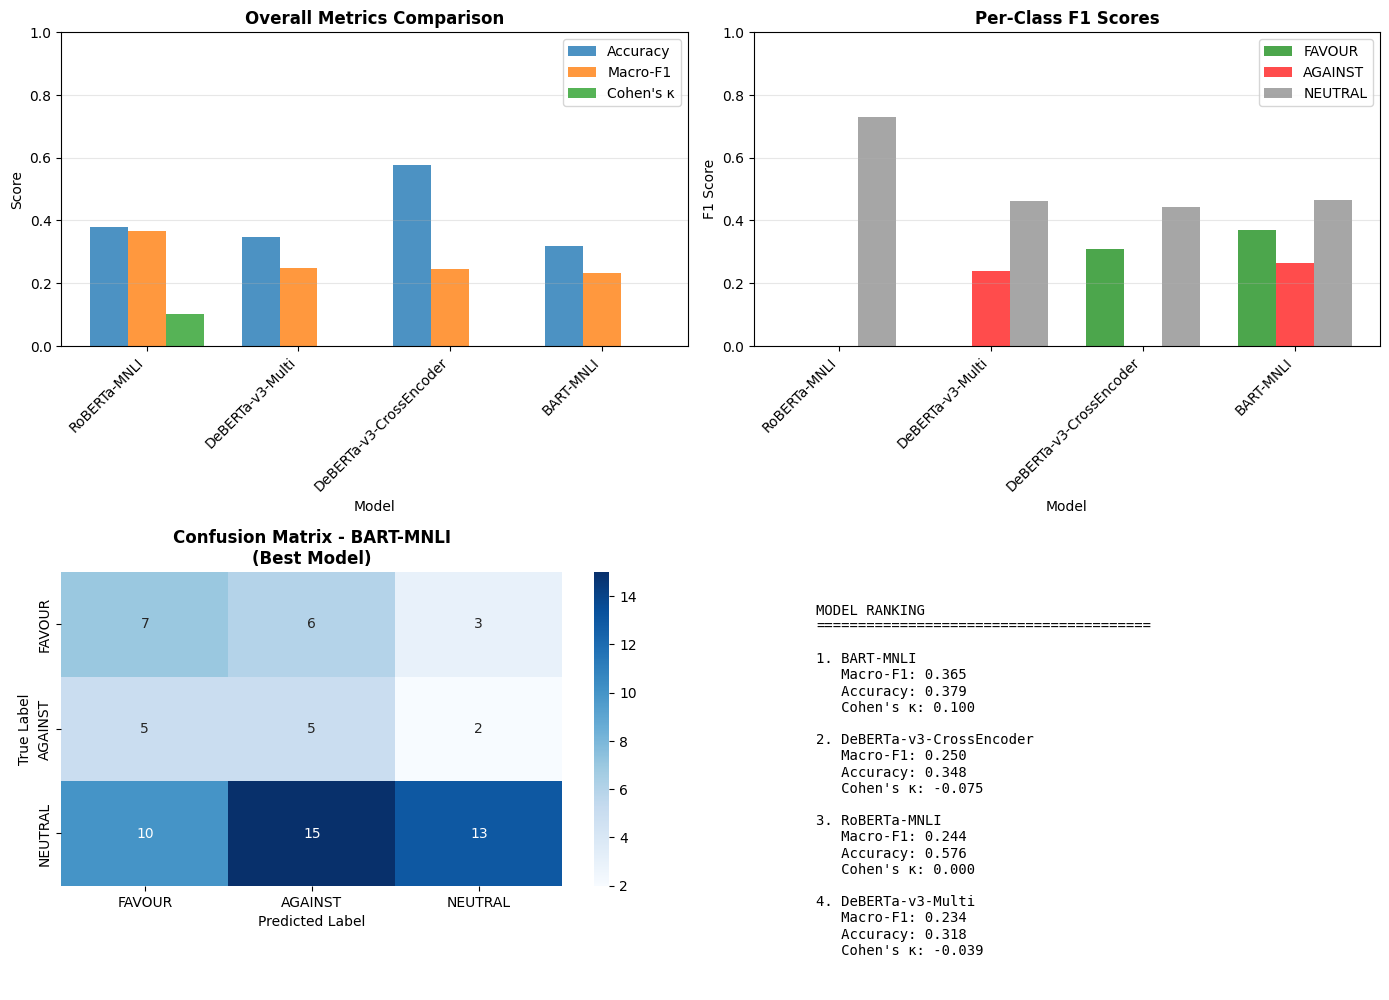


✓ Results saved to /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/reddit


In [13]:
# Get comparison metrics
metrics_df = comparison.get_metrics_summary()

print("\n" + "="*80)
print("MODEL COMPARISON - SUMMARY METRICS")
print("="*80)
print(metrics_df.to_string(index=False))

# Visualize comparison
fig = comparison.plot_comparison(figsize=(14, 10))
plt.tight_layout()
plt.show()

# Save comparison results
output_path = workspace_root / 'data' / '03_stance' / 'reddit'
output_path.mkdir(parents=True, exist_ok=True)

metrics_df.to_csv(output_path / 'model_comparison_metrics.csv', index=False)
fig.savefig(output_path / 'model_comparison.png', dpi=300, bbox_inches='tight')

print(f"\n✓ Results saved to {output_path}")

## 8. Select Best Model

Choose model based on metrics (prioritize Macro-F1).

In [ ]:
# Select best model based on Macro-F1
best_model_row = metrics_df.loc[metrics_df['macro_f1'].idxmax()]
best_model_name = best_model_row['model_name']
best_model_config = next(m for m in MODELS_TO_COMPARE if m['name'] == best_model_name)

print("\n" + "="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\n🏆 Selected Model: {best_model_name}")
print(f"Model ID: {best_model_config['model_name']}")
print(f"\nPerformance:")
print(f"  Macro-F1: {best_model_row['macro_f1']:.3f}")
print(f"  Accuracy: {best_model_row['accuracy']:.3f}")
print(f"  FAVOUR F1: {best_model_row['favour_f1']:.3f}")
print(f"  AGAINST F1: {best_model_row['against_f1']:.3f}")
print(f"  NEUTRAL F1: {best_model_row['neutral_f1']:.3f}")

# Save selection
model_selection = {
    'selected_model': best_model_name,
    'model_id': best_model_config['model_name'],
    'selection_date': datetime.now().isoformat(),
    'metrics': best_model_row.to_dict(),
    'selection_criteria': 'Macro-F1 score',
    'test_set_size': len(test_set_annotated)
}

with open(output_path / 'model_selection.json', 'w') as f:
    json.dump(model_selection, f, indent=2)

print(f"\n✓ Model selection saved to {output_path / 'model_selection.json'}")

## 9. Full Dataset Stance Detection - Comments

Apply selected model to all comments.

In [ ]:
# Initialize best model
print(f"Initializing {best_model_name} for full dataset processing...\n")
final_model = ImprovedNLIStanceModel(
    model_name=best_model_config['model_name'],
    confidence_threshold=0.04
)

# Process comments in batches
print("="*80)
print("PROCESSING COMMENTS")
print("="*80)
print(f"Total rows: {len(comments_df):,}")
print(f"Unique comments: {comments_df['comment_id'].nunique():,}")
print(f"Topics: {comments_df['topic_label'].nunique()}\n")

# Run stance detection
texts = comments_df['body'].tolist()
targets = comments_df['topic_label'].tolist()

print("Running stance detection...")
stance_results = final_model.batch_predict(
    texts=texts,
    targets=targets,
    batch_size=32,
    show_progress=True
)

# Add results to dataframe
comments_with_stance = comments_df.copy()
comments_with_stance['stance'] = stance_results['predicted_label']
comments_with_stance['stance_confidence'] = stance_results['confidence']
comments_with_stance['stance_prob_favour'] = stance_results['prob_favour']
comments_with_stance['stance_prob_against'] = stance_results['prob_against']
comments_with_stance['stance_prob_neutral'] = stance_results['prob_neutral']

print("\n✓ Comments stance detection complete!")
print(f"\nStance distribution:")
print(comments_with_stance['stance'].value_counts())
print(f"\nConfidence stats:")
print(comments_with_stance['stance_confidence'].describe())

## 10. Full Dataset Stance Detection - Submissions

Apply selected model to all submissions.

In [ ]:
# Process submissions
print("="*80)
print("PROCESSING SUBMISSIONS")
print("="*80)
print(f"Total rows: {len(submissions_df):,}")
print(f"Unique submissions: {submissions_df['submission_id_text'].nunique():,}")
print(f"Topics: {submissions_df['topic_label'].nunique()}\n")

# Run stance detection
texts = submissions_df['selftext'].tolist()
targets = submissions_df['topic_label'].tolist()

print("Running stance detection...")
stance_results = final_model.batch_predict(
    texts=texts,
    targets=targets,
    batch_size=32,
    show_progress=True
)

# Add results to dataframe
submissions_with_stance = submissions_df.copy()
submissions_with_stance['stance'] = stance_results['predicted_label']
submissions_with_stance['stance_confidence'] = stance_results['confidence']
submissions_with_stance['stance_prob_favour'] = stance_results['prob_favour']
submissions_with_stance['stance_prob_against'] = stance_results['prob_against']
submissions_with_stance['stance_prob_neutral'] = stance_results['prob_neutral']

print("\n✓ Submissions stance detection complete!")
print(f"\nStance distribution:")
print(submissions_with_stance['stance'].value_counts())
print(f"\nConfidence stats:")
print(submissions_with_stance['stance_confidence'].describe())

## 11. Save Results

Save stance-enhanced datasets to `data/03_stance/reddit/`.

In [ ]:
# Save results
output_path = workspace_root / 'data' / '03_stance' / 'reddit'
output_path.mkdir(parents=True, exist_ok=True)

print("Saving stance-enhanced datasets...\n")

# Save comments
comments_output = output_path / 'comments_with_stance.parquet'
write_parquet_safe(comments_with_stance, comments_output, show_progress=True)
print(f"✓ Comments saved: {comments_output}")
print(f"  Rows: {len(comments_with_stance):,}")
print(f"  Columns: {len(comments_with_stance.columns)}")

# Save submissions
submissions_output = output_path / 'submissions_with_stance.parquet'
write_parquet_safe(submissions_with_stance, submissions_output, show_progress=True)
print(f"\n✓ Submissions saved: {submissions_output}")
print(f"  Rows: {len(submissions_with_stance):,}")
print(f"  Columns: {len(submissions_with_stance.columns)}")

# Save metadata
metadata = {
    'creation_date': datetime.now().isoformat(),
    'model': {
        'name': best_model_name,
        'model_id': best_model_config['model_name'],
        'confidence_threshold': 0.04
    },
    'performance': model_selection['metrics'],
    'data': {
        'comments': {
            'total_rows': len(comments_with_stance),
            'unique_comments': int(comments_with_stance['comment_id'].nunique()),
            'stance_distribution': comments_with_stance['stance'].value_counts().to_dict()
        },
        'submissions': {
            'total_rows': len(submissions_with_stance),
            'unique_submissions': int(submissions_with_stance['submission_id_text'].nunique()),
            'stance_distribution': submissions_with_stance['stance'].value_counts().to_dict()
        }
    }
}

with open(output_path / 'stance_detection_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✓ Metadata saved: {output_path / 'stance_detection_metadata.json'}")

## 12. Quality Analysis

Analyze stance detection quality and create visualizations.

In [ ]:
# Combined analysis
all_data = pd.concat([
    comments_with_stance[['stance', 'stance_confidence', 'topic_label']].assign(content_type='comment'),
    submissions_with_stance[['stance', 'stance_confidence', 'topic_label']].assign(content_type='submission')
])

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall stance distribution
stance_counts = all_data['stance'].value_counts()
axes[0, 0].bar(stance_counts.index, stance_counts.values, color=['green', 'red', 'gray'])
axes[0, 0].set_title('Overall Stance Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(stance_counts.values):
    axes[0, 0].text(i, v, f'{v:,}\n({v/len(all_data):.1%})', ha='center', va='bottom')

# 2. Stance by content type
stance_by_type = pd.crosstab(all_data['content_type'], all_data['stance'], normalize='index') * 100
stance_by_type.plot(kind='bar', ax=axes[0, 1], color=['green', 'red', 'gray'])
axes[0, 1].set_title('Stance by Content Type', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].set_xlabel('')
axes[0, 1].legend(title='Stance')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

# 3. Confidence distribution by stance
for stance in ['FAVOUR', 'AGAINST', 'NEUTRAL']:
    data = all_data[all_data['stance'] == stance]['stance_confidence']
    axes[1, 0].hist(data, alpha=0.5, label=stance, bins=30)
axes[1, 0].set_title('Confidence Distribution by Stance', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Confidence')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

# 4. Top topics by stance
topic_stance = pd.crosstab(all_data['topic_label'], all_data['stance'])
topic_stance_pct = topic_stance.div(topic_stance.sum(axis=1), axis=0) * 100
top_topics = topic_stance.sum(axis=1).nlargest(10).index
topic_stance_pct.loc[top_topics].plot(kind='barh', stacked=True, ax=axes[1, 1], 
                                       color=['green', 'red', 'gray'])
axes[1, 1].set_title('Stance Distribution - Top 10 Topics', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Percentage')
axes[1, 1].set_ylabel('')
axes[1, 1].legend(title='Stance', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
fig.savefig(output_path / 'stance_quality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Quality analysis saved: {output_path / 'stance_quality_analysis.png'}")

## 13. Summary Statistics

In [ ]:
# Print summary
print("\n" + "="*80)
print("STANCE DETECTION SUMMARY")
print("="*80)

print(f"\n📊 Data Processed:")
print(f"  Comments: {len(comments_with_stance):,} rows ({comments_with_stance['comment_id'].nunique():,} unique)")
print(f"  Submissions: {len(submissions_with_stance):,} rows ({submissions_with_stance['submission_id_text'].nunique():,} unique)")
print(f"  Total: {len(all_data):,} text-topic pairs")

print(f"\n🤖 Model Used:")
print(f"  Name: {best_model_name}")
print(f"  Model ID: {best_model_config['model_name']}")
print(f"  Macro-F1: {best_model_row['macro_f1']:.3f}")
print(f"  Accuracy: {best_model_row['accuracy']:.3f}")

print(f"\n📈 Overall Results:")
print(f"  FAVOUR: {(all_data['stance'] == 'FAVOUR').sum():,} ({(all_data['stance'] == 'FAVOUR').mean():.1%})")
print(f"  AGAINST: {(all_data['stance'] == 'AGAINST').sum():,} ({(all_data['stance'] == 'AGAINST').mean():.1%})")
print(f"  NEUTRAL: {(all_data['stance'] == 'NEUTRAL').sum():,} ({(all_data['stance'] == 'NEUTRAL').mean():.1%})")

print(f"\n💪 Confidence:")
print(f"  Mean: {all_data['stance_confidence'].mean():.3f}")
print(f"  Median: {all_data['stance_confidence'].median():.3f}")
print(f"  High confidence (>0.7): {(all_data['stance_confidence'] > 0.7).mean():.1%}")

print(f"\n💾 Output Files:")
print(f"  {output_path / 'comments_with_stance.parquet'}")
print(f"  {output_path / 'submissions_with_stance.parquet'}")
print(f"  {output_path / 'model_comparison_metrics.csv'}")
print(f"  {output_path / 'model_selection.json'}")
print(f"  {output_path / 'stance_detection_metadata.json'}")

print("\n" + "="*80)
print("✓ STANCE DETECTION COMPLETE!")
print("="*80)